<a href="https://colab.research.google.com/github/gyuchangShim/MJU_AI/blob/MASK-RCNN/Mask_R_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# detectron2 git clone 및 환경 설정
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities (e.g. compiled operators).
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

  Using cached PyYAML-5.1.tar.gz (274 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.
fatal: destination path 'detectron2' already exists and is not an empty directory.


In [3]:
# torch, cuda, detectron2 version 확인
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2023 NVIDIA Corporation
Built on Tue_Aug_15_22:02:13_PDT_2023
Cuda compilation tools, release 12.2, V12.2.140
Build cuda_12.2.r12.2/compiler.33191640_0
torch:  2.3 ; cuda:  cu121
detectron2: 0.6


In [4]:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, random
import matplotlib.pyplot as plt

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultTrainer, DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.evaluation import COCOEvaluator
from detectron2.data import build_detection_test_loader

In [5]:
import os
import tensorflow as tf
from tensorflow.python.client import device_lib

print(device_lib.list_local_devices())
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

tf.test.is_gpu_available()
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpus[0], True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2152151366284329558
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 14626652160
locality {
  bus_id: 1
  links {
  }
}
incarnation: 2353132423333912625
physical_device_desc: "device: 0, name: Tesla T4, pci bus id: 0000:00:04.0, compute capability: 7.5"
xla_global_id: 416903419
]


In [6]:
# Drive Mount
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [7]:
dataset_dir = "/content/gdrive/MyDrive/pole_dataset/"
train_images_path = os.path.join(dataset_dir, "images")
train_annotations_path = os.path.join(dataset_dir, "annotations", "instances_default.json")
#val_images_path = os.path.join(dataset_dir, "val", "images")
#val_annotations_path = os.path.join(dataset_dir, "val", "annotations", "instances_val.json")

# COCO 데이터셋 등록
register_coco_instances("pole_train", {}, train_annotations_path, train_images_path)
#register_coco_instances("pole_val", {}, val_annotations_path, val_images_path)

# 데이터셋 메타데이터 로드
pole_metadata = MetadataCatalog.get("pole_train")

In [8]:
# 기본 설정 불러오기
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("pole_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")  # 사전 학습된 가중치 사용
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 5  # 학습 반복 수
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 32
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 4  # 클래스 수 (백그라운드를 제외한)

In [ ]:
# 이전 프로세스 확인
import psutil

for proc in psutil.process_iter():
    try:
        process_name = proc.name()
        if "python" in process_name and "colab" in process_name:
            print("이전 프로세스 발견:", process_name)
    except (psutil.NoSuchProcess, psutil.AccessDenied, psutil.ZombieProcess):
        pass

print("모든 프로세스 검색 완료.")

[06/04 04:49:21 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

roi_heads.box_predictor.bbox_pred.{bias, weight}
roi_heads.box_predictor.cls_score.{bias, weight}
roi_heads.mask_head.predictor.{bias, weight}


[06/04 04:49:22 d2.engine.train_loop]: Starting training from iteration 0


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/local/lib/python3.10/dist-packages/torch/functional.py:512: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3587.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


[06/04 04:49:37 d2.utils.events]:  eta: 0:00:00  iter: 4  total_loss: 3.395  loss_cls: 1.716  loss_box_reg: 0.6768  loss_mask: 0.6923  loss_rpn_cls: 0.154  loss_rpn_loc: 0.01959    time: 1.6551  last_time: 1.9192  data_time: 1.4417  last_data_time: 1.4871   lr: 0.00020005  max_mem: 2456M
[06/04 04:49:37 d2.engine.hooks]: Overall training speed: 3 iterations in 0:00:04 (1.6551 s / it)
[06/04 04:49:37 d2.engine.hooks]: Total training time: 0:00:07 (0:00:02 on hooks)


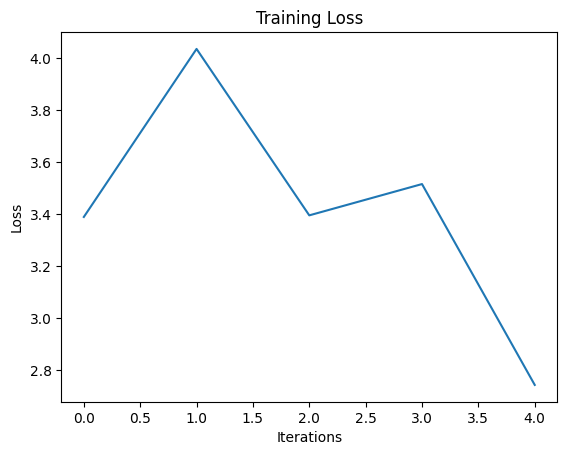

In [9]:
# CUDA 디버깅
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TORCH_USE_CUDA_DSA"] = '1'

# Trainer 정의
class LossAccTrainer(DefaultTrainer):
    def __init__(self, cfg):
        super().__init__(cfg)
        self.losses = []

    def run_step(self):
        super().run_step()
        # 손실 저장
        self.losses.append(self.storage.history("total_loss").latest())

    def train(self, *args, **kwargs):
        super().train(*args, **kwargs)
        return self.losses

# Trainer 생성
trainer = LossAccTrainer(cfg)
trainer.resume_or_load(resume=False)
losses = trainer.train()

# 손실 시각화
plt.plot(losses)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.show()